## 1. Importing the libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score

## 2.Importing the dataset

In [2]:
df = pd.read_csv("G:/MangeshDataScience/Practice/WorkEx/Classification/Churn_Modelling/Churn_Modelling.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.rename(columns= {'Exited' : 'Target' } , inplace = True )

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Target           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.drop(['CustomerId', 'Surname', 'RowNumber'], axis = 1, inplace=True)

In [7]:
X = df.drop(['Target'], axis = 1)
y = df['Target']

In [8]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [9]:
y.value_counts()

0    7963
1    2037
Name: Target, dtype: int64

In [10]:
X[['CreditScore', 'Balance','EstimatedSalary']].describe(percentiles=(0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

,CreditScore,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,100090.239881
std,96.653299,62397.405202,57510.492818
min,350.000000,0.000000,11.580000
1%,432.000000,0.000000,1842.825300
5%,489.000000,0.000000,9851.818500
10%,521.000000,0.000000,20273.580000
25%,584.000000,0.000000,51002.110000
50%,652.000000,97198.540000,100193.915000
75%,718.000000,127644.240000,149388.247500


### 2.1. Label encoding for char features i.e. Geography & Gender

In [11]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
X.Geography = LE.fit_transform(X.Geography)
print(X.Geography.value_counts())
print('============')
X.Gender = LE.fit_transform(X.Gender)
print(X.Gender.value_counts())

0    5014
1    2509
2    2477
Name: Geography, dtype: int64
1    5457
0    4543
Name: Gender, dtype: int64


### 2.2. Identifying outliers

In [12]:
def outliers_cap(x):
    x = x.clip(lower = x.quantile(0.01))
    x = x.clip(upper = x.quantile(0.99))
    return(x)

### 2.3. Removing outliers

In [13]:
X[['CreditScore', 'Balance','EstimatedSalary']] = X[['CreditScore', 'Balance','EstimatedSalary']].apply(lambda x: outliers_cap(x))

In [14]:
X[['CreditScore', 'Balance','EstimatedSalary']].describe(percentiles=(0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

,CreditScore,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000
mean,650.743200,76369.720704,100089.576990
std,96.115361,62172.016053,57477.436802
min,432.000000,0.000000,1842.825300
1%,432.000000,0.000000,1843.235853
5%,489.000000,0.000000,9851.818500
10%,521.000000,0.000000,20273.580000
25%,584.000000,0.000000,51002.110000
50%,652.000000,97198.540000,100193.915000
75%,718.000000,127644.240000,149388.247500


### 2.4. TrainTestSplit

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [16]:
print(f'The shape of training data is {X_train.shape} ')
print(f'The shape of testing data is {X_test.shape} ')
print(f'The response rate of training data is {y_train.mean()}')
print(f'The response rate of testing data is {y_test.mean()}')

The shape of training data is (7500, 10) 
The shape of testing data is (2500, 10) 
The response rate of training data is 0.20226666666666668
The response rate of testing data is 0.208


## 3. Building the model evaluation matrix

In [17]:
def print_score1(clf, X_train, y_train, X_test, y_test, train = True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print('Training Result:========================================================')
        print(f'The accuracy score for the model is: {accuracy_score(y_train,pred )*100: .2f}%')
        print('________________________________________________________________________')
        print(f'The classification report for the model is: \n{clf_report}')
        print('________________________________________________________________________')
        plot_confusion_matrix(clf,X_train, y_train, cmap='viridis', display_labels=['Not Churn', 'Churn'])
        print('========================================================================')
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print('Training Result:========================================================')
        print(f'The accuracy score for the model is: {accuracy_score(y_test,pred )*100: .2f}%')
        print('________________________________________________________________________')
        print(f'The classification report for the model is: \n{clf_report}')
        print('________________________________________________________________________')
        plot_confusion_matrix(clf, X_test, y_test, cmap='cividis', display_labels=['Not Churn', 'Churn'])
        plt.show()

## 4. Buidling various models

#### 4.1. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  79.19%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.802297     0.381720  0.791867     0.592009      0.717228
recall        0.980779     0.046803  0.791867     0.513791      0.791867
f1-score      0.882605     0.083382  0.791867     0.482994      0.720949
support    5983.000000  1517.000000  0.791867  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.68%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.79

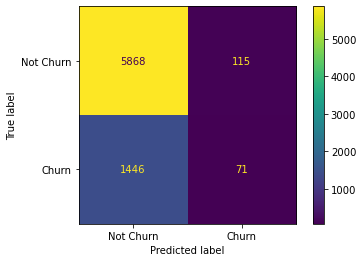

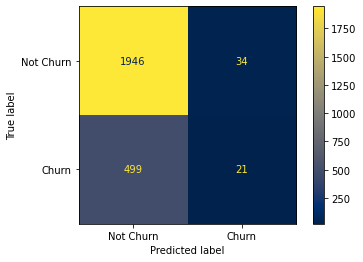

In [19]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print_score1(lr, X_train, y_train, X_test, y_test, train = True)
print_score1(lr, X_train, y_train, X_test, y_test, train = False)

#### 4.2. Decision Tree

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    5983.0  1517.0       1.0     7500.0        7500.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.60%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.875000    0.509259     0.796     0.692130      0.798926
recal

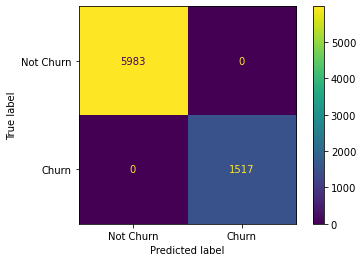

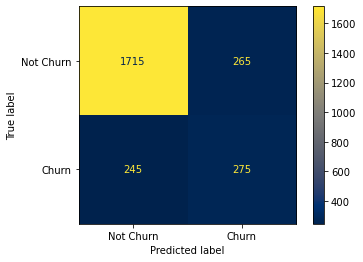

In [20]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
print_score1(dt, X_train, y_train, X_test, y_test, train = True)
print_score1(dt, X_train, y_train, X_test, y_test, train = False)

#### 4.3. Random Forest

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    5983.0  1517.0       1.0     7500.0        7500.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  86.20%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.871422    0.792642     0.862     0.832032      0.855036
recal

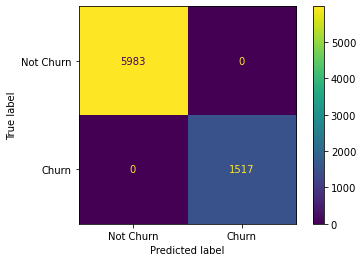

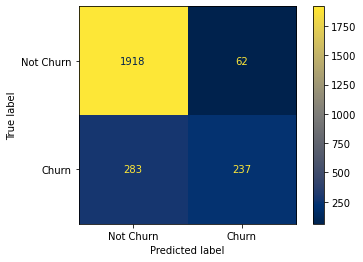

In [21]:
rf = RandomForestClassifier().fit(X_train, y_train)
print_score1(rf, X_train, y_train, X_test, y_test, train = True)
print_score1(rf, X_train, y_train, X_test, y_test, train = False)

#### 4.4. Adaboost

Training Result:========================================================
The accuracy score for the model is:  85.68%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.874905     0.732424    0.8568     0.803664      0.846085
recall        0.957379     0.460119    0.8568     0.708749      0.856800
f1-score      0.914286     0.565182    0.8568     0.739734      0.843674
support    5983.000000  1517.000000    0.8568  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  85.72%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.87

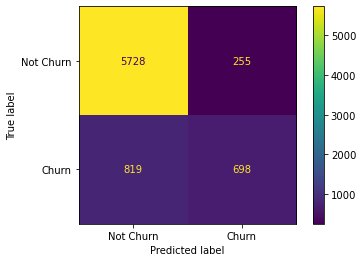

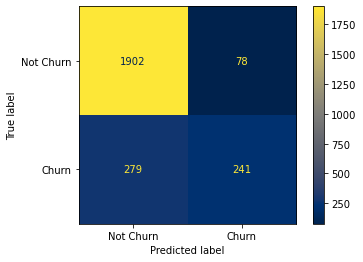

In [22]:
adb = AdaBoostClassifier().fit(X_train, y_train)
print_score1(adb, X_train, y_train, X_test, y_test, train=True)
print_score1(adb, X_train, y_train, X_test, y_test, train=False)

#### 4.5. Gradient Boosting

Training Result:========================================================
The accuracy score for the model is:  87.19%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.878733     0.819540  0.871867     0.849137      0.866760
recall        0.973759     0.470007  0.871867     0.721883      0.871867
f1-score      0.923809     0.597403  0.871867     0.760606      0.857788
support    5983.000000  1517.000000  0.871867  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  86.40%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.87

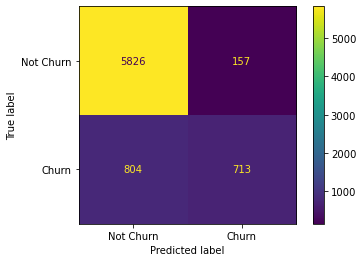

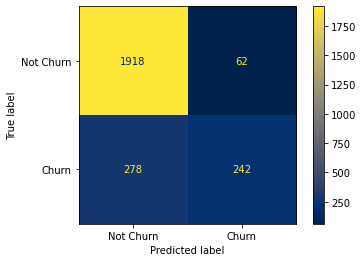

In [23]:
gbx = GradientBoostingClassifier().fit(X_train, y_train)
print_score1(gbx, X_train, y_train, X_test, y_test, train=True)
print_score1(gbx, X_train, y_train, X_test, y_test, train=False)

#### 4.6. XGBoost

Training Result:========================================================
The accuracy score for the model is:  96.16%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.958166     0.978210    0.9616     0.968188      0.962220
recall        0.995320     0.828609    0.9616     0.911965      0.961600
f1-score      0.976390     0.897216    0.9616     0.936803      0.960375
support    5983.000000  1517.000000    0.9616  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  86.08%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.87

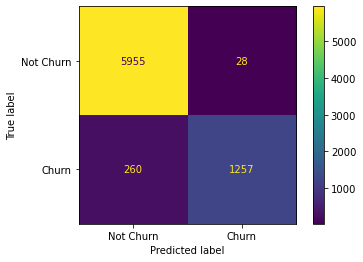

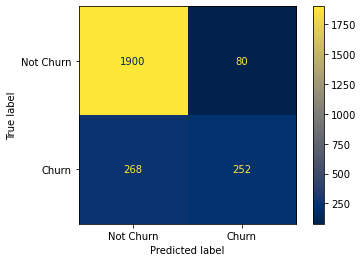

In [24]:
xgb = XGBClassifier(verbosity = 0)
xgb.fit(X_train, y_train)
print_score1(xgb, X_train, y_train, X_test, y_test, train=True)
print_score1(xgb, X_train, y_train, X_test, y_test, train=False)

#### 4.7. Support Vector Machines

Training Result:========================================================
The accuracy score for the model is:  79.77%
________________________________________________________________________
The classification report for the model is: 
                     0       1  accuracy    macro avg  weighted avg
precision     0.797733     0.0  0.797733     0.398867      0.636378
recall        1.000000     0.0  0.797733     0.500000      0.797733
f1-score      0.887488     0.0  0.797733     0.443744      0.707979
support    5983.000000  1517.0  0.797733  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.20%
________________________________________________________________________
The classification report for the model is: 
                     0      1  accuracy    macro avg  weighted avg
precision     0.792000    0.0     0.792     0.39

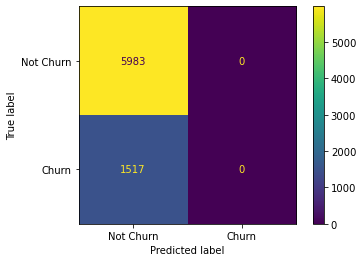

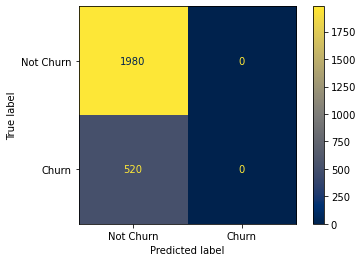

In [25]:
svc = SVC().fit(X_train, y_train)
print_score1(svc, X_train, y_train, X_test, y_test, train=True)
print_score1(svc, X_train, y_train, X_test, y_test, train=False)

#### 4.8. Naive-Bayes

Training Result:========================================================
The accuracy score for the model is:  78.53%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.801878     0.319066  0.785333     0.560472      0.704221
recall        0.970750     0.054054  0.785333     0.512402      0.785333
f1-score      0.878270     0.092446  0.785333     0.485358      0.719324
support    5983.000000  1517.000000  0.785333  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.48%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.79

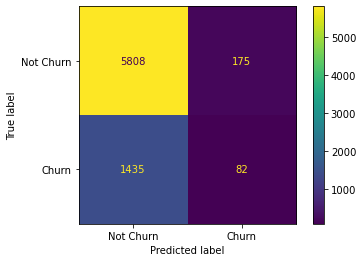

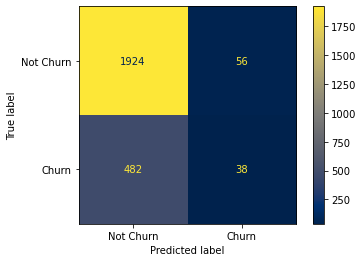

In [26]:
nb = GaussianNB().fit(X_train, y_train)
print_score1(nb, X_train, y_train, X_test, y_test, train=True)
print_score1(nb, X_train, y_train, X_test, y_test, train=False)

### Hyperparameter Tunning

#### 4.9. Decision Tree

Fitting 5 folds for each of 2052 candidates, totalling 10260 fits
Training Result:========================================================
The accuracy score for the model is:  83.91%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.837956     0.857143  0.839067     0.847550      0.841837
recall        0.989637     0.245221  0.839067     0.617429      0.839067
f1-score      0.907502     0.381343  0.839067     0.644423      0.801078
support    5983.000000  1517.000000  0.839067  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  84.04%
________________________________________________________________________
The classification report for the model is: 
                     0  

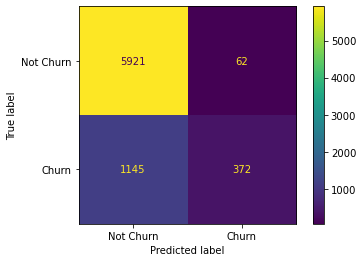

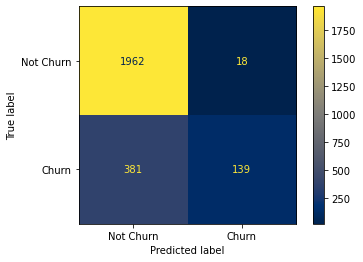

In [27]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1,10))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))}
tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="precision", n_jobs=-1, verbose=1, cv=5)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score1(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score1(tree_clf, X_train, y_train, X_test, y_test, train=False)

#### 4.10. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  79.20%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.802324     0.383784     0.792     0.593054      0.717667
recall        0.980946     0.046803     0.792     0.513874      0.792000
f1-score      0.882689     0.083431     0.792     0.483060      0.721026
support    5983.000000  1517.000000     0.792  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.68%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.79

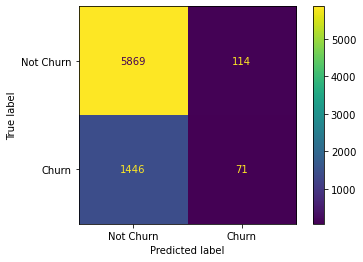

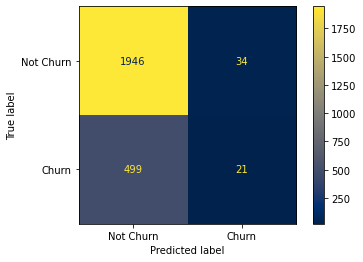

In [28]:
lr = LogisticRegression()
gird_values = {'penalty': ['l1', 'l2'], 'C' : [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}
grid_clf = GridSearchCV(lr, gird_values, scoring='precision')
grid_clf.fit(X_train, y_train)
print_score1(grid_clf, X_train, y_train, X_test, y_test, train=True)
print_score1(grid_clf, X_train, y_train, X_test, y_test, train=False)

#### 4.11. Support Vector Machine

In [29]:
model = SVC(kernel='rbf',C=1,gamma=.000001)
model.fit(X_train, y_train)

SVC(C=1, gamma=1e-06)

Training Result:========================================================
The accuracy score for the model is:  89.85%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.887389     0.997368  0.898533     0.942379      0.909634
recall        0.999666     0.499670  0.898533     0.749668      0.898533
f1-score      0.940187     0.665788  0.898533     0.802988      0.884685
support    5983.000000  1517.000000  0.898533  7500.000000   7500.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.12%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.79

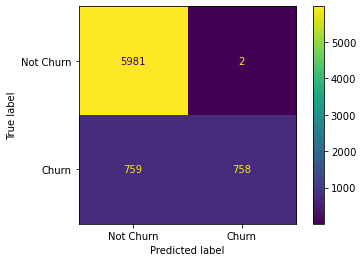

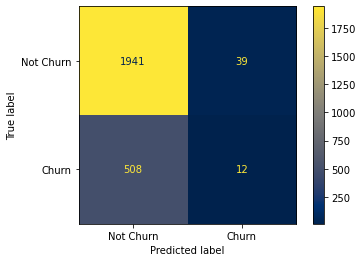

In [30]:
print_score1(model, X_train, y_train, X_test, y_test, train=True)
print_score1(model, X_train, y_train, X_test, y_test, train=False)

## 5. Working with sampled data

### 5.1. Merging the data into df_train

In [31]:
df_train = X_train.join(y_train)

In [32]:
df_train.Target.value_counts()

0    5983
1    1517
Name: Target, dtype: int64

In [33]:
df_train_majority = df_train[df_train.Target == 0]
df_train_minority = df_train[df_train.Target == 1]

In [34]:
print(df_train_majority.Target.count())
print('==============================')
print(df_train_minority.Target.count())
print('==============================')
df_train.Target.value_counts()

5983
1517


0    5983
1    1517
Name: Target, dtype: int64

#### 5.2. Creating upsampled dataset

In [35]:
df_train_minority_upsampled = resample(df_train_minority, replace=True, n_samples=5983, random_state = 1)
df_upsampled = pd.concat([df_train_majority, df_train_minority_upsampled])

In [36]:
df_upsampled.Target.value_counts()

1    5983
0    5983
Name: Target, dtype: int64

In [37]:
X_upsampled = df_upsampled.drop(['Target'], axis=1)
y_upsampled = df_upsampled.Target

#### 5.3. Creating downsampled dataset

In [38]:
df_train_majority_downsampled = resample(df_train_majority, replace=False, n_samples=1517, random_state = 1)
df_downsampled = pd.concat([df_train_majority_downsampled, df_train_minority])

In [39]:
df_downsampled.Target.value_counts()

1    1517
0    1517
Name: Target, dtype: int64

In [40]:
X_downsampled = df_downsampled.drop(['Target'], axis=1)
y_downsampled = df_downsampled.Target

### 6. Working with upsampled data

#### 6.1. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  65.30%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.655407     0.650700  0.653017      0.653053      0.653053
recall        0.645328     0.660705  0.653017      0.653017      0.653017
f1-score      0.650328     0.655664  0.653017      0.652996      0.652996
support    5983.000000  5983.000000  0.653017  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  66.72%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

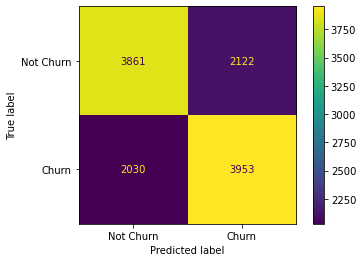

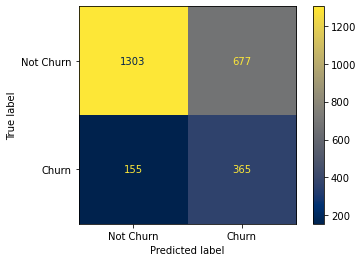

In [41]:
lrup = LogisticRegression()
lrup.fit(X_upsampled, y_upsampled)
print_score1(lrup, X_upsampled, y_upsampled, X_test, y_test, train = True)
print_score1(lrup, X_upsampled, y_upsampled, X_test, y_test, train = False)

#### 6.2. Decision Tree

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    5983.0  5983.0       1.0    11966.0       11966.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.00%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.864662    0.495050      0.79     0.679856      0.787782
recal

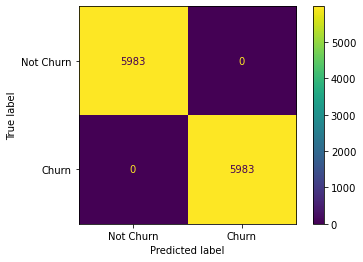

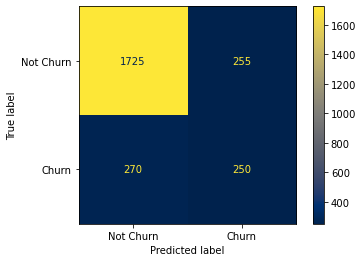

In [42]:
dtup = DecisionTreeClassifier().fit(X_upsampled, y_upsampled)
print_score1(dtup, X_upsampled, y_upsampled, X_test, y_test, train = True)
print_score1(dtup, X_upsampled, y_upsampled, X_test, y_test, train = False)

#### 6.3. Random Forest

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    5983.0  5983.0       1.0    11966.0       11966.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  86.28%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.886632    0.731070    0.8628     0.808851      0.854275
recal

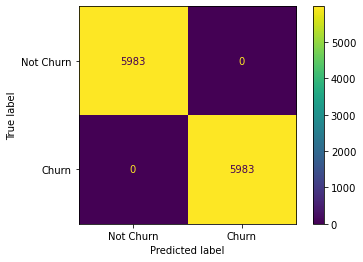

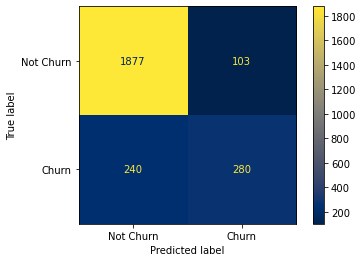

In [43]:
rfup = RandomForestClassifier().fit(X_upsampled, y_upsampled)
print_score1(rfup, X_upsampled, y_upsampled, X_test, y_test, train = True)
print_score1(rfup, X_upsampled, y_upsampled, X_test, y_test, train = False)

#### 6.4. Adaboost

Training Result:========================================================
The accuracy score for the model is:  77.24%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.760512     0.785327  0.772355      0.772919      0.772919
recall        0.795086     0.749624  0.772355      0.772355      0.772355
f1-score      0.777415     0.767060  0.772355      0.772237      0.772237
support    5983.000000  5983.000000  0.772355  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.76%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

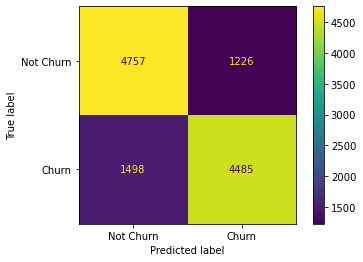

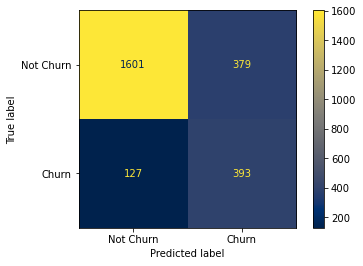

In [44]:
adbup = AdaBoostClassifier().fit(X_upsampled, y_upsampled)
print_score1(adbup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(adbup, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.5. Gradient Boosting

Training Result:========================================================
The accuracy score for the model is:  80.53%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.796365     0.814751  0.805282      0.805558      0.805558
recall        0.820324     0.790239  0.805282      0.805282      0.805282
f1-score      0.808167     0.802308  0.805282      0.805238      0.805238
support    5983.000000  5983.000000  0.805282  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  80.84%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

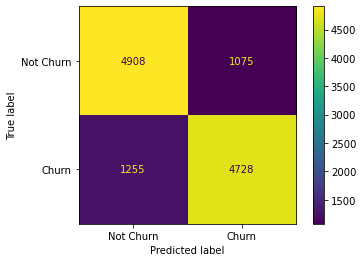

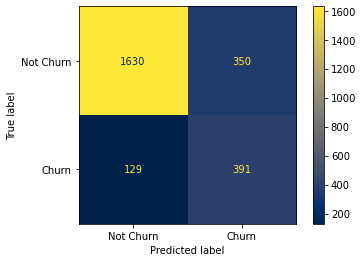

In [45]:
gbxup = GradientBoostingClassifier().fit(X_upsampled, y_upsampled)
print_score1(gbxup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(gbxup, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.6. XGBoost

Training Result:========================================================
The accuracy score for the model is:  97.66%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.982406     0.970933    0.9766      0.976669      0.976669
recall        0.970583     0.982617    0.9766      0.976600      0.976600
f1-score      0.976459     0.976740    0.9766      0.976600      0.976600
support    5983.000000  5983.000000    0.9766  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  84.28%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

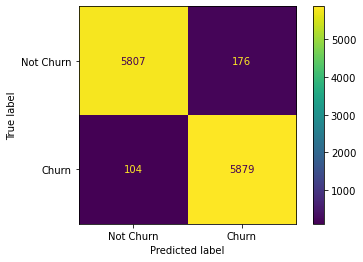

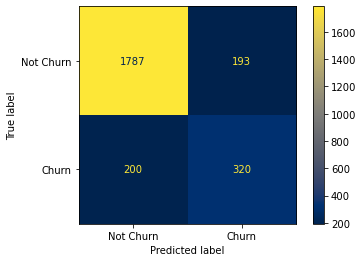

In [46]:
xgbup = XGBClassifier()
xgbup.fit(X_upsampled, y_upsampled)
print_score1(xgbup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(xgbup, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.7. Support Vector Machines

Training Result:========================================================
The accuracy score for the model is:  57.22%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.613445     0.552954  0.572205      0.583200      0.583200
recall        0.390440     0.753970  0.572205      0.572205      0.572205
f1-score      0.477173     0.638003  0.572205      0.557588      0.557588
support    5983.000000  5983.000000  0.572205  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  46.88%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

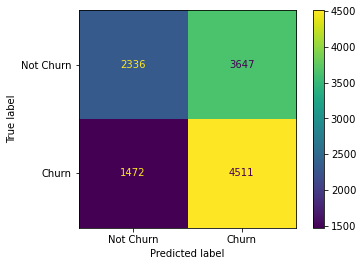

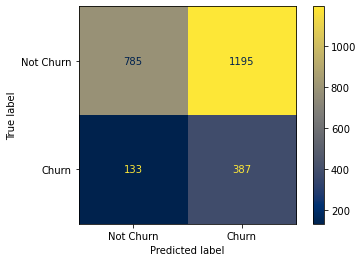

In [47]:
svcup = SVC().fit(X_upsampled, y_upsampled)
print_score1(svcup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(svcup, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.8. Naive-Bayes

Training Result:========================================================
The accuracy score for the model is:  68.92%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.679057     0.700567  0.689203      0.689812      0.689812
recall        0.717533     0.660872  0.689203      0.689203      0.689203
f1-score      0.697765     0.680141  0.689203      0.688953      0.688953
support    5983.000000  5983.000000  0.689203  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  71.12%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

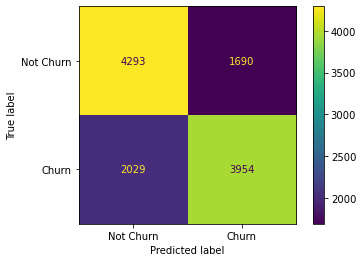

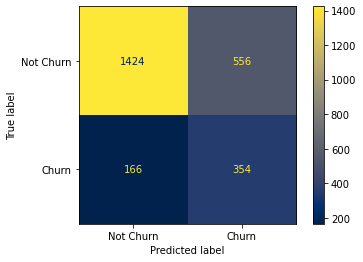

In [48]:
nbup = GaussianNB().fit(X_upsampled, y_upsampled)
print_score1(nbup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(nbup, X_upsampled, y_upsampled, X_test, y_test, train=False)

### Hyperparameter Tunning

#### 6.9. Decision Tree

Fitting 5 folds for each of 2052 candidates, totalling 10260 fits
Training Result:========================================================
The accuracy score for the model is:  71.21%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.685472     0.747658  0.712101      0.716565      0.716565
recall        0.783888     0.640314  0.712101      0.712101      0.712101
f1-score      0.731384     0.689835  0.712101      0.710610      0.710610
support    5983.000000  5983.000000  0.712101  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  75.72%
________________________________________________________________________
The classification report for the model is: 
                   

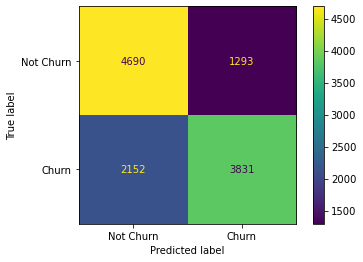

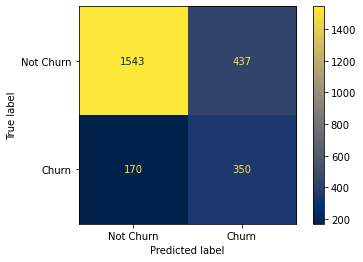

In [49]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1,10))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))}
tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="precision", n_jobs=-1, verbose=1, cv=5)
tree_cv.fit(X_upsampled, y_upsampled)
best_params = tree_cv.best_params_
tree_clfup = DecisionTreeClassifier(**best_params)
tree_clfup.fit(X_upsampled, y_upsampled)
print_score1(tree_clfup, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(tree_clfup, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.10. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  65.30%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.655407     0.650700  0.653017      0.653053      0.653053
recall        0.645328     0.660705  0.653017      0.653017      0.653017
f1-score      0.650328     0.655664  0.653017      0.652996      0.652996
support    5983.000000  5983.000000  0.653017  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  66.72%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

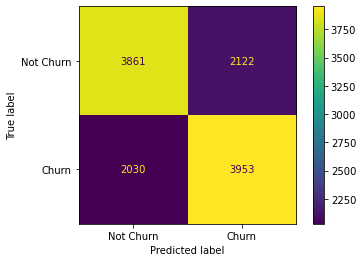

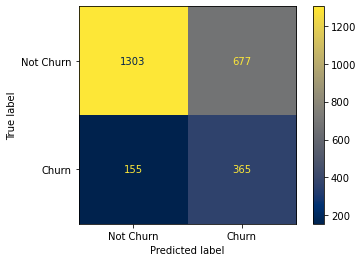

In [50]:
lr = LogisticRegression()
gird_values = {'penalty': ['l1', 'l2'], 'C' : [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}
grid_clf = GridSearchCV(lr, gird_values, scoring='precision')
grid_clf.fit(X_upsampled, y_upsampled)
print_score1(grid_clf, X_upsampled, y_upsampled, X_test, y_test, train=True)
print_score1(grid_clf, X_upsampled, y_upsampled, X_test, y_test, train=False)

#### 6.11. Support Vector Machine

In [51]:
model = SVC(kernel='rbf',C=1,gamma=.000001)
model.fit(X_upsampled, y_upsampled)

SVC(C=1, gamma=1e-06)

Training Result:========================================================
The accuracy score for the model is:  88.85%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy     macro avg  weighted avg
precision     0.873774     0.904472  0.888517      0.889123      0.889123
recall        0.908240     0.868795  0.888517      0.888517      0.888517
f1-score      0.890674     0.886275  0.888517      0.888474      0.888474
support    5983.000000  5983.000000  0.888517  11966.000000  11966.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  69.96%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision    

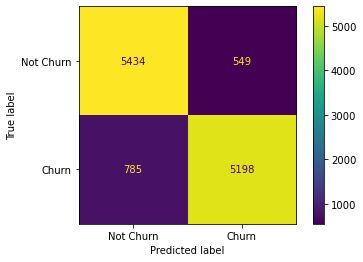

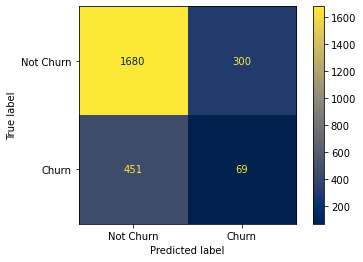

In [52]:
print_score1(model, X_upsampled, y_upsampled, X_test, y_test, train = True)
print_score1(model, X_upsampled, y_upsampled, X_test, y_test, train = False)

## 7. Working with downsampled data

#### 7.1. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  65.59%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.660122     0.651895    0.6559     0.656008      0.656008
recall        0.642716     0.669084    0.6559     0.655900      0.655900
f1-score      0.651303     0.660377    0.6559     0.655840      0.655840
support    1517.000000  1517.000000    0.6559  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  66.04%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.89

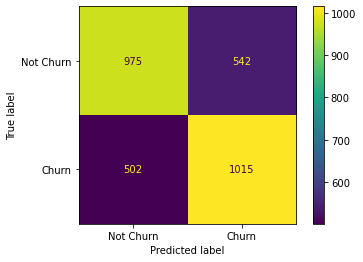

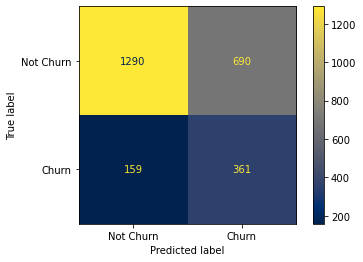

In [53]:
lrdown = LogisticRegression()
lrdown.fit(X_downsampled, y_downsampled)
print_score1(lrdown, X_downsampled, y_downsampled, X_test, y_test, train = True)
print_score1(lrdown, X_downsampled, y_downsampled, X_test, y_test, train = False)

#### 7.2. Decision Tree

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    1517.0  1517.0       1.0     3034.0        3034.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  69.88%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.903353    0.381001    0.6988     0.642177      0.794704
recal

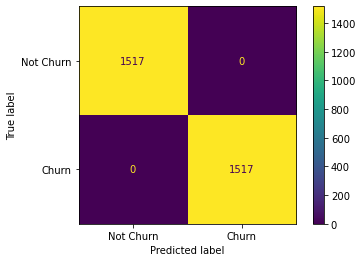

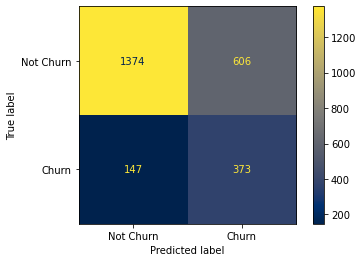

In [54]:
dtdown = DecisionTreeClassifier().fit(X_downsampled, y_downsampled)
print_score1(dtdown, X_downsampled, y_downsampled, X_test, y_test, train = True)
print_score1(dtdown, X_downsampled, y_downsampled, X_test, y_test, train = False)

#### 7.3. Random Forest

Training Result:========================================================
The accuracy score for the model is:  100.00%
________________________________________________________________________
The classification report for the model is: 
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    1517.0  1517.0       1.0     3034.0        3034.0
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.08%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.925774    0.498099    0.7908     0.711937      0.836818
recal

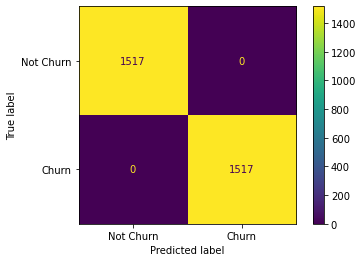

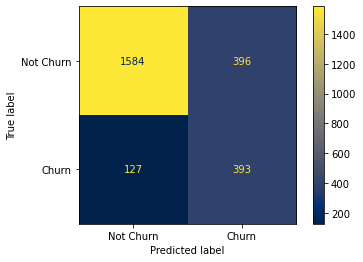

In [55]:
rfdown = RandomForestClassifier().fit(X_downsampled, y_downsampled)
print_score1(rfdown, X_downsampled, y_downsampled, X_test, y_test, train = True)
print_score1(rfdown, X_downsampled, y_downsampled, X_test, y_test, train = False)

#### 7.4. Adaboost

Training Result:========================================================
The accuracy score for the model is:  77.13%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.764290     0.778605  0.771259     0.771448      0.771448
recall        0.784443     0.758075  0.771259     0.771259      0.771259
f1-score      0.774236     0.768203  0.771259     0.771219      0.771219
support    1517.000000  1517.000000  0.771259  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.80%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.92

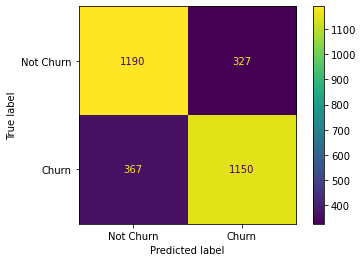

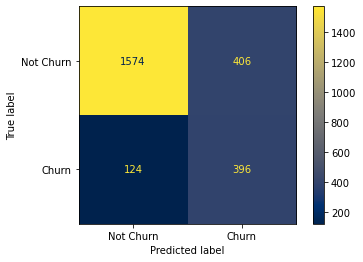

In [56]:
adbdown = AdaBoostClassifier().fit(X_downsampled, y_downsampled)
print_score1(adbdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(adbdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.5. Gradient Boosting

Training Result:========================================================
The accuracy score for the model is:  80.65%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.793190     0.821133  0.806526     0.807162      0.807162
recall        0.829268     0.783784  0.806526     0.806526      0.806526
f1-score      0.810828     0.802024  0.806526     0.806426      0.806426
support    1517.000000  1517.000000  0.806526  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  79.72%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.93

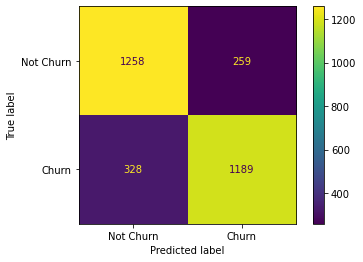

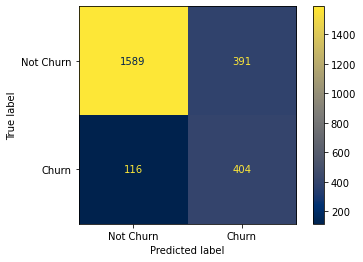

In [57]:
gbxdown = GradientBoostingClassifier().fit(X_downsampled, y_downsampled)
print_score1(gbxdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(gbxdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.6. XGBoost

Training Result:========================================================
The accuracy score for the model is:  98.78%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.983029     0.992676  0.987805     0.987853      0.987853
recall        0.992749     0.982861  0.987805     0.987805      0.987805
f1-score      0.987865     0.987744  0.987805     0.987805      0.987805
support    1517.000000  1517.000000  0.987805  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  78.04%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.92

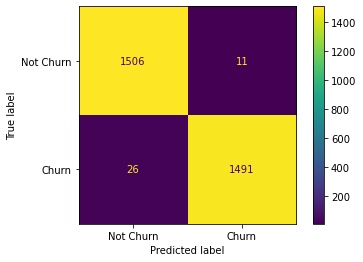

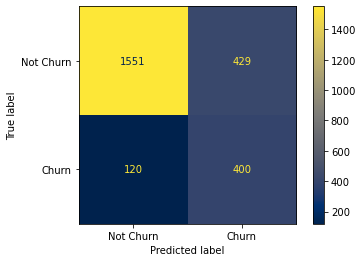

In [58]:
xgbdown = XGBClassifier()
xgbdown.fit(X_downsampled, y_downsampled)
print_score1(xgbdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(xgbdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.7. Support Vector Machines

Training Result:========================================================
The accuracy score for the model is:  57.65%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.618367     0.556475  0.576467     0.587421      0.587421
recall        0.399473     0.753461  0.576467     0.576467      0.576467
f1-score      0.485382     0.640157  0.576467     0.562770      0.562770
support    1517.000000  1517.000000  0.576467  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  46.92%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.85

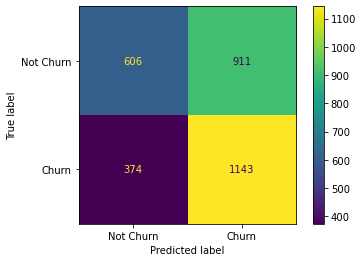

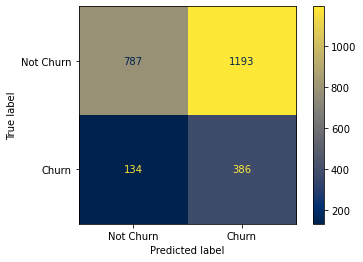

In [59]:
svcdown = SVC().fit(X_downsampled, y_downsampled)
print_score1(svcdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(svcdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.8. Naive-Bayes

Training Result:========================================================
The accuracy score for the model is:  68.92%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.678040     0.701828  0.689189     0.689934      0.689934
recall        0.720501     0.657877  0.689189     0.689189      0.689189
f1-score      0.698626     0.679143  0.689189     0.688884      0.688884
support    1517.000000  1517.000000  0.689189  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  71.64%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.89

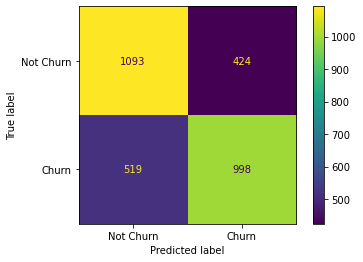

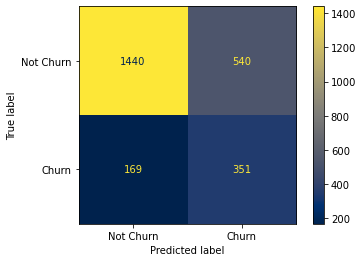

In [60]:
nbdown = GaussianNB().fit(X_downsampled, y_downsampled)
print_score1(nbdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(nbdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

### Hyperparameter Tunning

#### 7.9. Decision Tree

Fitting 5 folds for each of 2052 candidates, totalling 10260 fits
Training Result:========================================================
The accuracy score for the model is:  66.94%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.731532     0.633576  0.669413     0.682554      0.682554
recall        0.535267     0.803560  0.669413     0.669413      0.669413
f1-score      0.618196     0.708515  0.669413     0.663355      0.663355
support    1517.000000  1517.000000  0.669413  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  59.16%
________________________________________________________________________
The classification report for the model is: 
                     0  

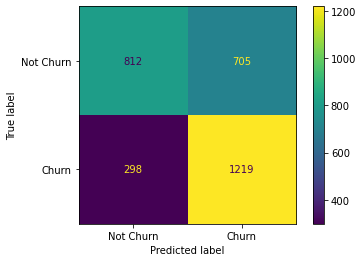

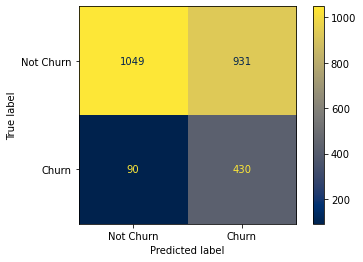

In [61]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1,10))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))}
tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="precision", n_jobs=-1, verbose=1, cv=5)
tree_cv.fit(X_downsampled, y_downsampled)
best_params = tree_cv.best_params_
tree_clfdown = DecisionTreeClassifier(**best_params)
tree_clfdown.fit(X_downsampled, y_downsampled)
print_score1(tree_clfdown, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(tree_clfdown, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.10. Logistic Regression

Training Result:========================================================
The accuracy score for the model is:  65.56%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.659675     0.651671   0.65557     0.655673      0.655673
recall        0.642716     0.668425   0.65557     0.655570      0.655570
f1-score      0.651085     0.659941   0.65557     0.655513      0.655513
support    1517.000000  1517.000000   0.65557  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  66.04%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.89

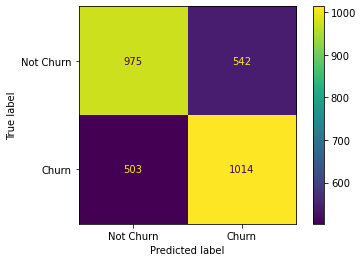

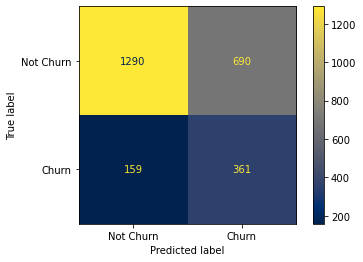

In [62]:
lr = LogisticRegression()
gird_values = {'penalty': ['l1', 'l2'], 'C' : [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}
grid_clf = GridSearchCV(lr, gird_values, scoring='precision')
grid_clf.fit(X_downsampled, y_downsampled)
print_score1(grid_clf, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(grid_clf, X_downsampled, y_downsampled, X_test, y_test, train=False)

#### 7.11. Support Vector Machine

In [63]:
model = SVC(kernel='rbf',C=1,gamma=.000001)
model.fit(X_downsampled, y_downsampled)

SVC(C=1, gamma=1e-06)

Training Result:========================================================
The accuracy score for the model is:  89.12%
________________________________________________________________________
The classification report for the model is: 
                     0            1  accuracy    macro avg  weighted avg
precision     0.859044     0.929761  0.891233     0.894403      0.894403
recall        0.936058     0.846407  0.891233     0.891233      0.891233
f1-score      0.895899     0.886128  0.891233     0.891014      0.891014
support    1517.000000  1517.000000  0.891233  3034.000000   3034.000000
________________________________________________________________________
Training Result:========================================================
The accuracy score for the model is:  46.64%
________________________________________________________________________
The classification report for the model is: 
                     0           1  accuracy    macro avg  weighted avg
precision     0.82

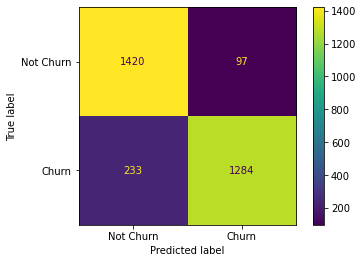

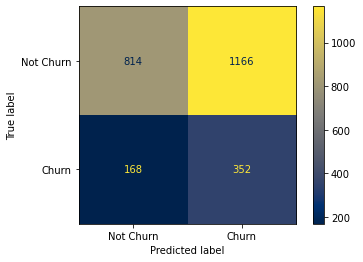

In [64]:
print_score1(model, X_downsampled, y_downsampled, X_test, y_test, train=True)
print_score1(model, X_downsampled, y_downsampled, X_test, y_test, train=False)

### 8. Deep Learning

In [65]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [66]:
model = Sequential([
          Dense(200 , activation='sigmoid',),  # hidden layer 1
          Dropout(0.6),  # regu

          Dense(100 , activation='relu' , kernel_initializer='he_normal'),  # hidden layer 2
          Dropout(0.8),


          Dense(50 , activation='sigmoid'), # hidden layer 3
          Dropout(0.8),


          Dense(25 , activation='relu', kernel_initializer='he_normal'),  # hidden layer 4
          Dropout(0.8),


          Dense(12 , activation='sigmoid'),  # hidden layer 5
          Dropout(0.8),
    
          Dense(1 , activation='sigmoid')  # output layer 
])

In [67]:
model.compile(optimizer = 'SGD' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [68]:
model.fit(X_train , y_train , epochs=50 , validation_split=0.2 , batch_size=32)

Epoch 1/50
188/188 [==============================] - 7s 6ms/step - loss: 0.6436 - accuracy: 0.6963 - val_loss: 0.5101 - val_accuracy: 0.7967
Epoch 2/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5734 - accuracy: 0.7898 - val_loss: 0.5080 - val_accuracy: 0.7967
Epoch 3/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5463 - accuracy: 0.7980 - val_loss: 0.5084 - val_accuracy: 0.7967
Epoch 4/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5398 - accuracy: 0.7980 - val_loss: 0.5096 - val_accuracy: 0.7967
Epoch 5/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5273 - accuracy: 0.7980 - val_loss: 0.5093 - val_accuracy: 0.7967
Epoch 6/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5210 - accuracy: 0.7980 - val_loss: 0.5081 - val_accuracy: 0.7967
Epoch 7/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5151 - accuracy: 0.7980 - val_loss: 0.5075 - val_accuracy: 0.7967
Epoch 

In [69]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_train = y_pred_train > 0.5
y_pred_test = y_pred_test > 0.5
print('Training Accuracy Score:==========', accuracy_score(y_train, y_pred_train))
print('**********************************************************************')
print('Testing Accuracy Score:==========', accuracy_score(y_test, y_pred_test))

Training Accuracy Score:========== 0.7977333333333333
**********************************************************************
Testing Accuracy Score:========== 0.792


### 9. Evaluating the performance of all the models

#### 9.1. Classification Reports and Accuracy Scores

In [70]:
model_names = [ lr, dt, rf, adb, gbx, xgb, svc, nb, tree_clf, 
          lrup, dtup, rfup, adbup, gbxup, xgbup, svcup, nbup, tree_clfup, 
          lrdown, dtdown, rfdown, adbdown, gbxdown, xgbdown, svcdown, nbdown, tree_clfdown ]

In [71]:
Training_Accuracy_Scores = []
Testing_Accuracy_Scores = []
Training_Recall_Scores = []
Testing_Recall_Scores = []
Training_Precision_Scores = []
Testing_Precision_Scores = []
for i in model_names:
    i.fit(X_train, y_train)
    Training_Accuracy_Scores.append(accuracy_score(y_train, i.predict(X_train)))
    Testing_Accuracy_Scores.append(accuracy_score(y_test, i.predict(X_test)))
    Training_Recall_Scores.append(recall_score(y_train, i.predict(X_train)))
    Testing_Recall_Scores.append(recall_score(y_test, i.predict(X_test)))
    Training_Precision_Scores.append(precision_score(y_train, i.predict(X_train)))
    Testing_Precision_Scores.append(precision_score(y_test, i.predict(X_test)))

In [72]:
indices = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Ada Boosting', 'Gradient Boosting', 'XGBoost', 'SVM',
           'Naive Bayes', 'Decision Tree with hyperparametr tunning', 'Logistic Regression with upsampled', 
           'Decision Tree with upsampled', 'Random Forest with upsampled', 'Ada Boosting with upsampled',
          'Gradient Boosting with upsampled', 'XGBoost with upsampled', 'SVC with upsampled', 'Naive Bayes with upsampled',
          'Decision Tree with upsampled and hyperparameter tunning', 'Logistic Regression with downsampled',
          'Decision Tree with downsampled', 'Random Forest  with downsampled', 'Ada Boosting with downsampled',
          'Gradient Boosting with downsampled', 'XGBoost with downsampled', 'SVC with downsampled',
           'Naive Bayes with downsampled', 'Decision Tree with downsampled and hyperparameter tunning']

In [73]:
table_data = {"Training Accuracy": ['{:.0%}'.format(item) for item in Training_Accuracy_Scores],
              "Testing Accuracy": ['{:.0%}'.format(item) for item in Testing_Accuracy_Scores],
              "Training Precision": ['{:.0%}'.format(item) for item in Training_Precision_Scores],
              "Testing Precision" : ['{:.0%}'.format(item) for item in Testing_Precision_Scores],
              "Training Recall"   : ['{:.0%}'.format(item) for item in Training_Recall_Scores],
              "Testing Recall"    : ['{:.0%}'.format(item) for item in Testing_Recall_Scores]}
table_dataframe = pd.DataFrame(data=table_data, index=indices)
table_dataframe

,Training Accuracy,Testing Accuracy,Training Precision,Testing Precision,Training Recall,Testing Recall
Logistic Regression,79%,79%,38%,38%,5%,4%
Decision Tree,100%,80%,100%,51%,100%,55%
Random Forest,100%,86%,100%,80%,100%,45%
Ada Boosting,86%,86%,73%,76%,46%,46%
Gradient Boosting,87%,86%,82%,80%,47%,47%
XGBoost,96%,86%,98%,76%,83%,48%
SVM,80%,79%,0%,0%,0%,0%
Naive Bayes,79%,78%,32%,40%,5%,7%
Decision Tree with hyperparametr tunning,100%,79%,100%,50%,100%,53%
Logistic Regression with upsampled,79%,79%,38%,38%,5%,4%


#### 9.2. Confusion Matrix

#### 9.2.1. training data

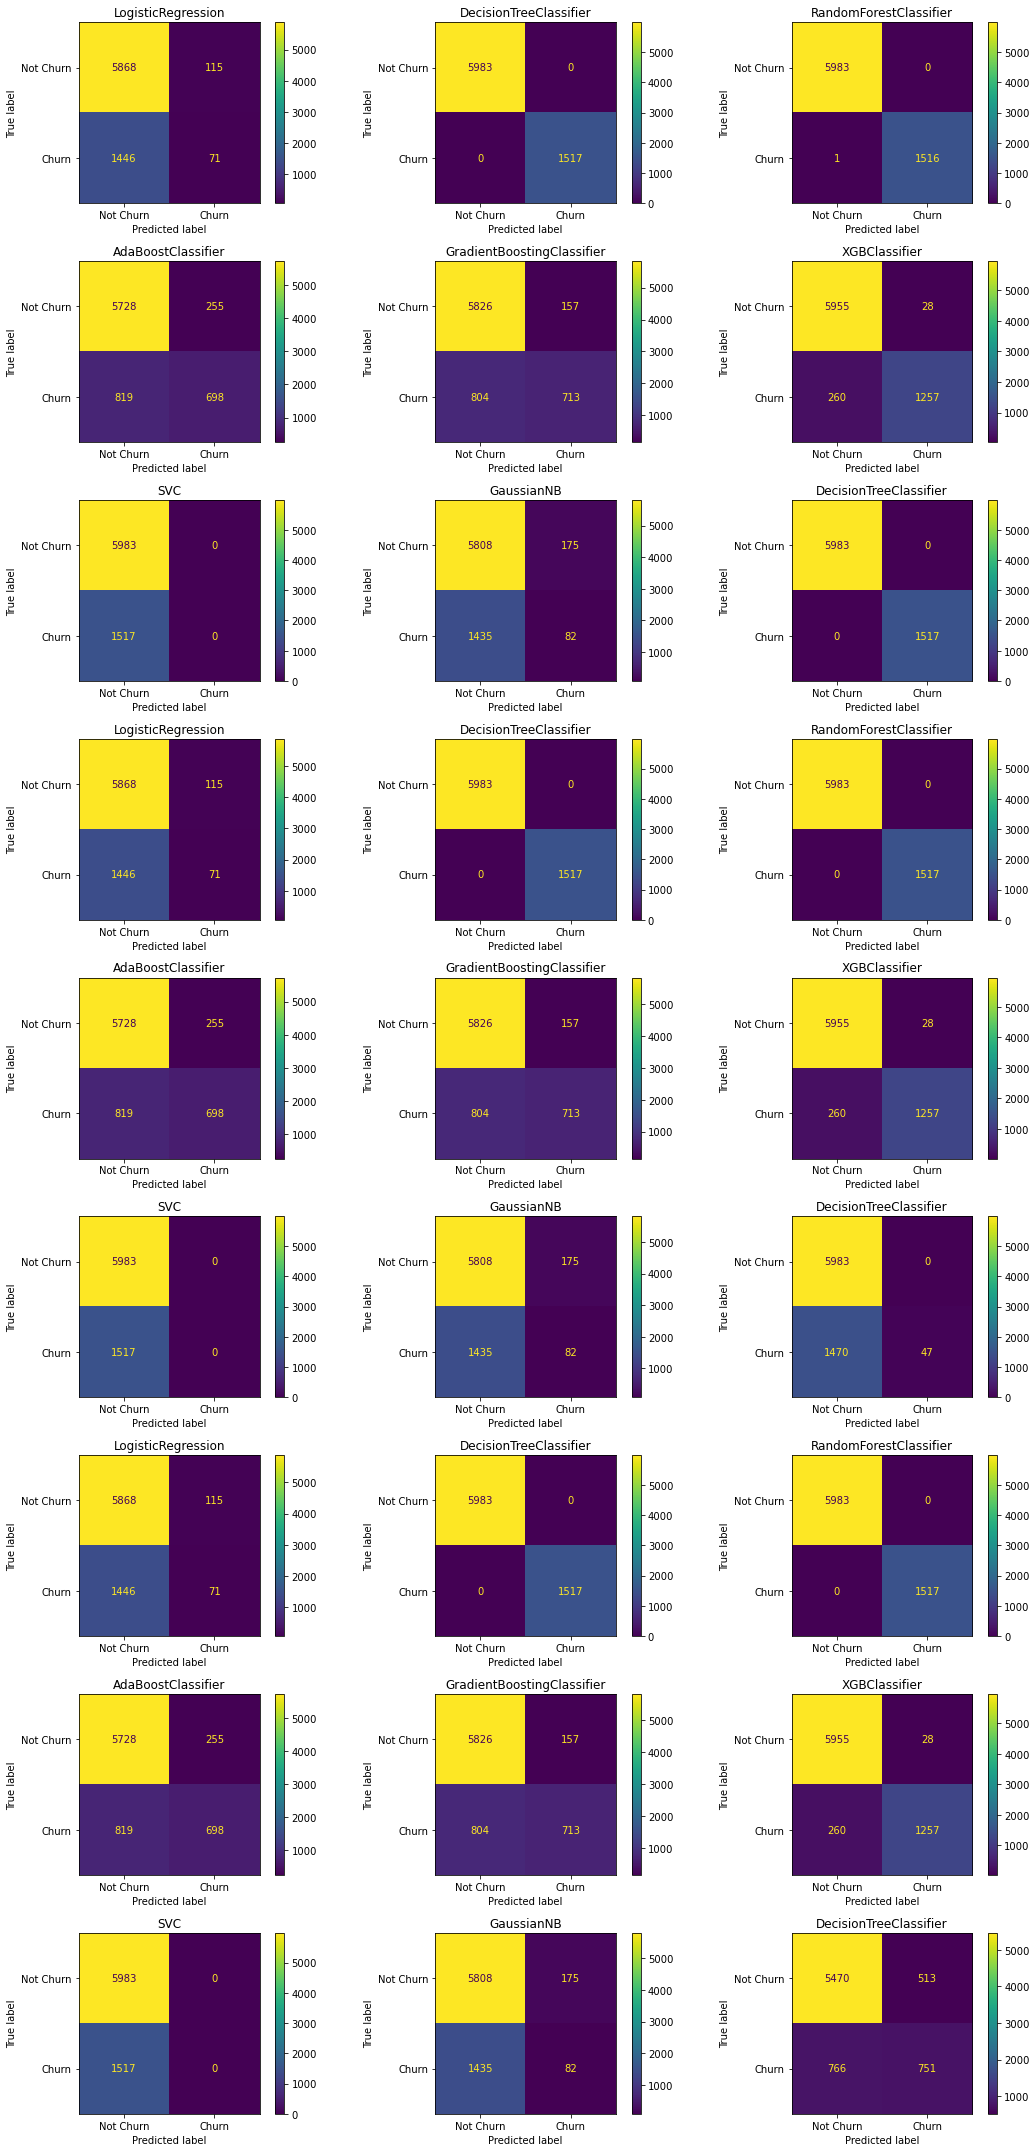

In [91]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15,30))
for cls, ax in zip(model_names, axes.flatten()):
    plot_confusion_matrix(cls, X_train, y_train, ax=ax, cmap='viridis', display_labels=['Not Churn', 'Churn'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

#### 9.2.2. testing data

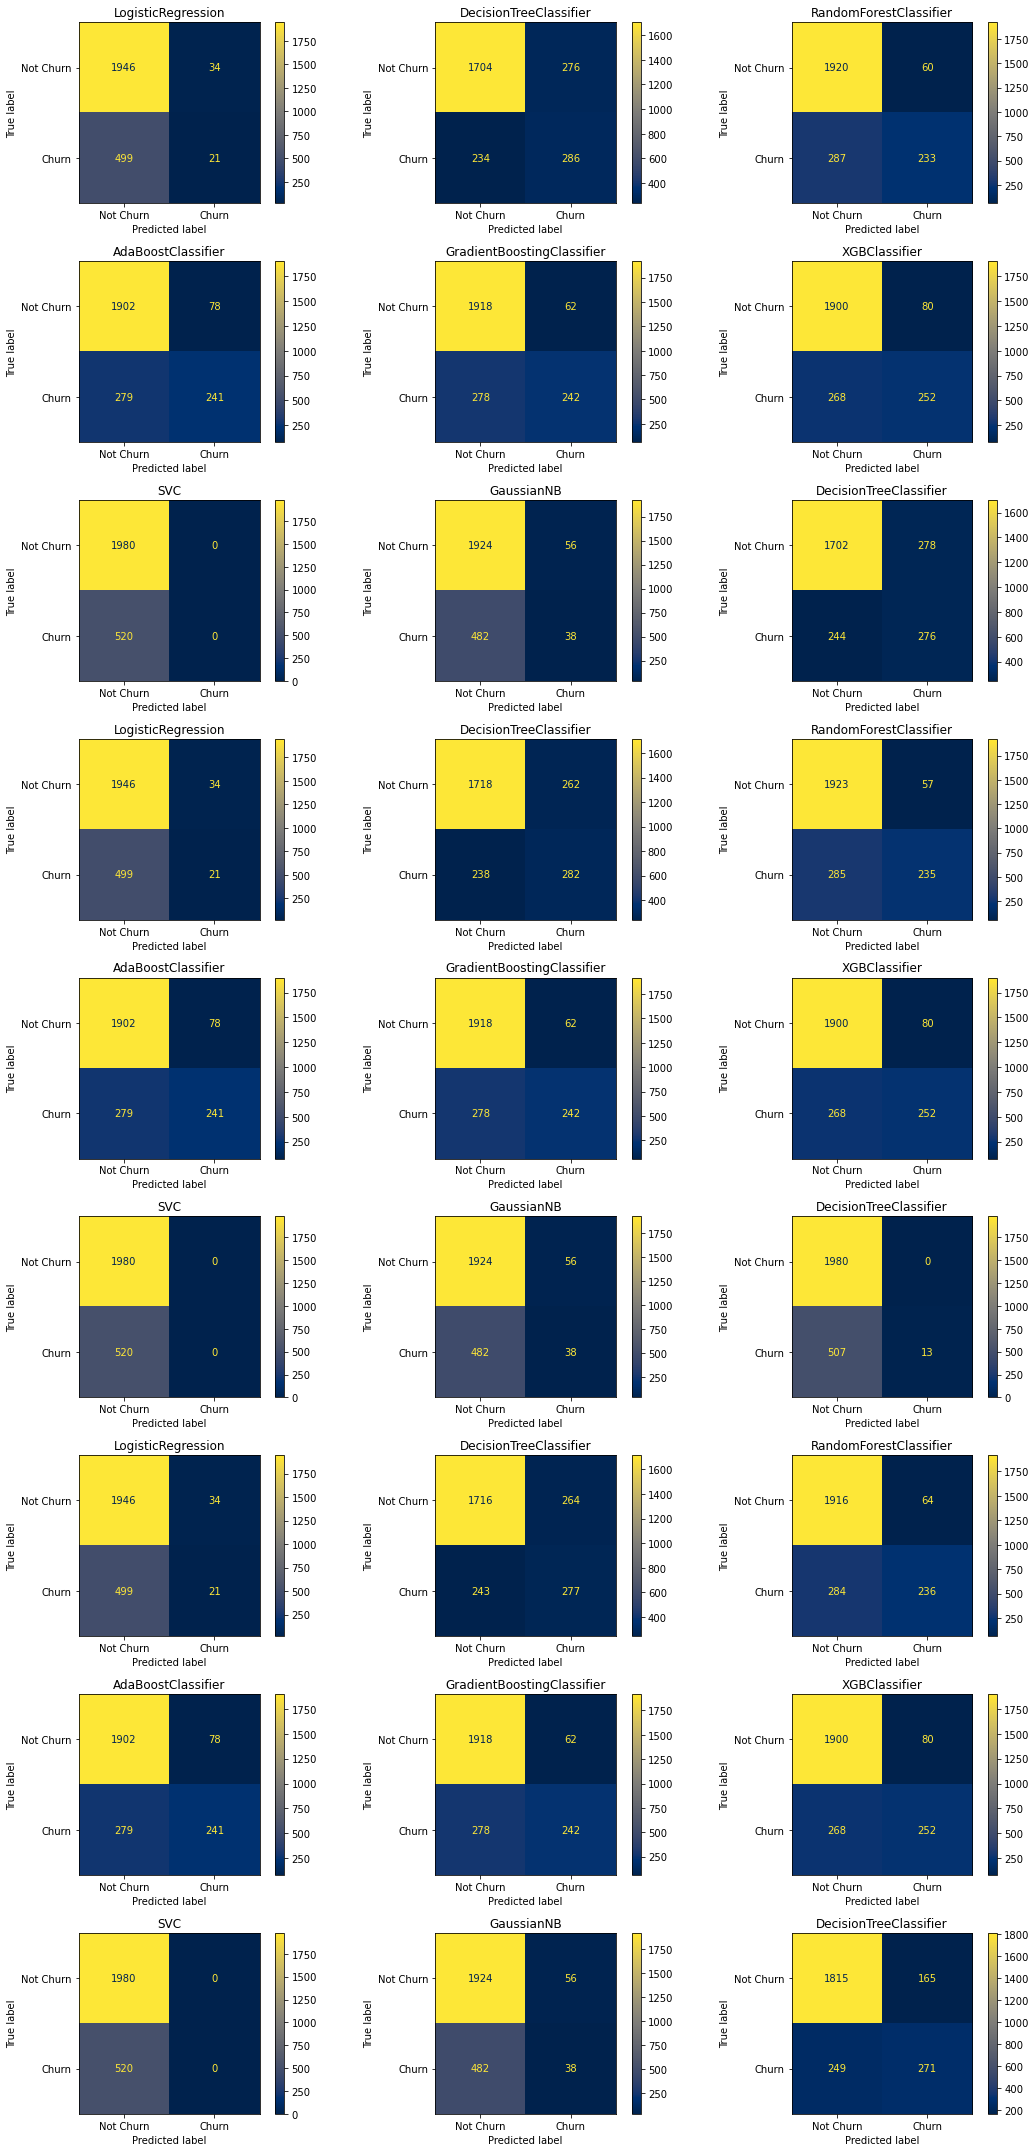

In [92]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15,30))
for cls, ax in zip(model_names, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='cividis', display_labels=['Not Churn', 'Churn'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()